Label Mapping: {'Iris-setosa': np.int64(0), 'Iris-versicolor': np.int64(1), 'Iris-virginica': np.int64(2)}
Dataset size: 150

=== STRATIFIED Split 80_10_10 ===

=== STRATIFIED Split 70_15_15 ===

=== RANDOM Split 80_10_10 ===

=== RANDOM Split 70_15_15 ===

=== Summary Table ===
                                          accuracy  precision_macro  \
split_type split_ratio method                                         
stratified 80_10_10    baseline           0.733333         0.746032   
                       random_oversample  0.733333         0.746032   
                       smote_k2           0.733333         0.746032   
           70_15_15    baseline           0.791667         0.812121   
                       random_oversample  0.791667         0.812121   
                       smote_k2           0.791667         0.812121   
random     80_10_10    baseline           0.866667         0.896825   
                       random_oversample  0.866667         0.896825   
          

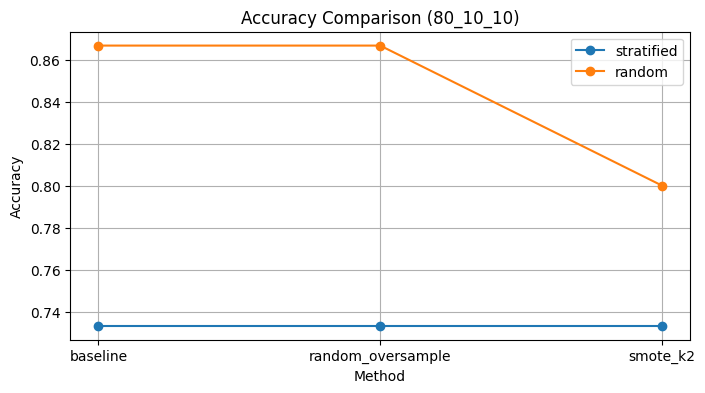

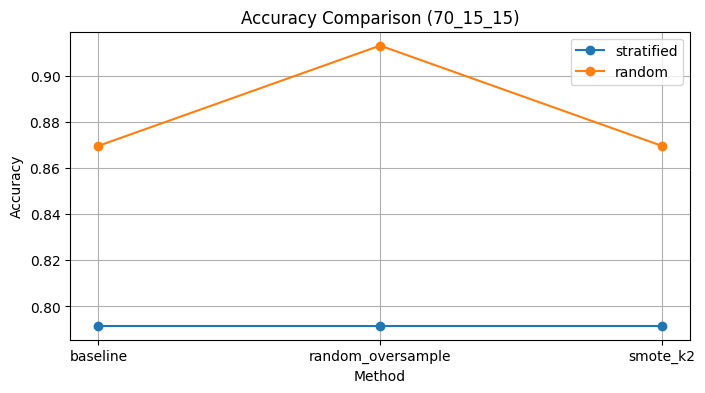

In [2]:
# iris_linear_regression_experiments_v3.py
# ----------------------------------------------------
# Compare Stratified vs Random Splitting
# with Baseline, Random Oversampling, and SMOTE
# ----------------------------------------------------
# pip install numpy pandas scikit-learn matplotlib imbalanced-learn
# ----------------------------------------------------

import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# ---------------------------
# Linear regression helper functions (One-vs-Rest)
# ---------------------------
def fit_linear_regressor(X, y):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    theta = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y
    return theta

def predict_scores(X, thetas):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    return np.vstack([X_b @ theta for theta in thetas]).T

def train_one_vs_rest(X, y, class_labels):
    thetas = []
    for c in class_labels:
        y_bin = (y == c).astype(float)
        thetas.append(fit_linear_regressor(X, y_bin))
    return np.array(thetas)

# ---------------------------
# Split methods
# ---------------------------
def stratified_equal_splits(df, label_col, proportions=(0.8, 0.1, 0.1), random_state=None):
    rng = np.random.default_rng(random_state)
    classes = df[label_col].unique()
    train_list, val_list, test_list = [], [], []
    for c in classes:
        sub = df[df[label_col] == c].sample(frac=1, random_state=int(rng.integers(0, 2**31-1)))
        n = len(sub)
        n_train = int(np.floor(proportions[0] * n))
        n_val = int(np.floor(proportions[1] * n))
        n_test = n - n_train - n_val
        train_list.append(sub.iloc[:n_train])
        val_list.append(sub.iloc[n_train:n_train + n_val])
        test_list.append(sub.iloc[n_train + n_val:])
    return (
        pd.concat(train_list).sample(frac=1, random_state=42).reset_index(drop=True),
        pd.concat(val_list).sample(frac=1, random_state=42).reset_index(drop=True),
        pd.concat(test_list).sample(frac=1, random_state=42).reset_index(drop=True),
    )

def random_split(df, label_col=None, proportions=(0.8, 0.1, 0.1), random_state=None):
    df_shuffled = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    n = len(df_shuffled)
    n_train = int(n * proportions[0])
    n_val = int(n * proportions[1])
    train = df_shuffled.iloc[:n_train]
    val = df_shuffled.iloc[n_train:n_train + n_val]
    test = df_shuffled.iloc[n_train + n_val:]
    return train, val, test

# ---------------------------
# Sampling utilities
# ---------------------------
def random_oversample(df, label_col, random_state=None):
    rng = np.random.default_rng(random_state)
    counts = df[label_col].value_counts()
    max_count = counts.max()
    groups = []
    for cls, cnt in counts.items():
        sub = df[df[label_col] == cls]
        if cnt < max_count:
            extra = sub.sample(n=max_count - cnt, replace=True, random_state=int(rng.integers(0, 2**31-1)))
            sub = pd.concat([sub, extra])
        groups.append(sub)
    return pd.concat(groups).sample(frac=1, random_state=42).reset_index(drop=True)

def apply_smote(X, y, k_neighbors=5, random_state=None):
    sm = SMOTE(k_neighbors=k_neighbors, random_state=random_state)
    return sm.fit_resample(X, y)

# ---------------------------
# Evaluation utilities
# ---------------------------
def evaluate_multiclass(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
    }

def train_and_eval(X_train, y_train, X_val, y_val, class_labels):
    thetas = train_one_vs_rest(X_train, y_train, class_labels)
    scores_val = predict_scores(X_val, thetas)
    preds_val = np.argmax(scores_val, axis=1)
    metrics = evaluate_multiclass(y_val, preds_val)
    return metrics, thetas

# ---------------------------
# Load Dataset
# ---------------------------
df = pd.read_csv("Iris.csv")
if 'Id' in df.columns:
    df.drop(columns=['Id'], inplace=True)

le = LabelEncoder()
df['label'] = le.fit_transform(df['Species'])
class_labels = sorted(df['label'].unique())
features = [c for c in df.columns if c not in ('Species', 'label')]

print("Label Mapping:", dict(zip(le.classes_, class_labels)))
print("Dataset size:", len(df))

# ---------------------------
# Experiment Config
# ---------------------------
split_settings = {
    '80_10_10': (0.8, 0.1, 0.1),
    '70_15_15': (0.7, 0.15, 0.15)
}

split_types = {
    'stratified': stratified_equal_splits,
    'random': random_split
}

results = defaultdict(dict)

# ---------------------------
# Main Experiment Loop
# ---------------------------
for split_type, split_func in split_types.items():
    for name, props in split_settings.items():
        print(f"\n=== {split_type.upper()} Split {name} ===")
        train_df, val_df, test_df = split_func(df, 'label', proportions=props, random_state=42)

        X_train, y_train = train_df[features].values, train_df['label'].values
        X_val, y_val = val_df[features].values, val_df['label'].values
        X_test, y_test = test_df[features].values, test_df['label'].values

        # ---- Baseline ----
        metrics_val, thetas = train_and_eval(X_train, y_train, X_val, y_val, class_labels)
        preds_test = np.argmax(predict_scores(X_test, thetas), axis=1)
        results[(split_type, name, 'baseline')] = evaluate_multiclass(y_test, preds_test)

        # ---- Random Oversampling ----
        train_bal = random_oversample(train_df, 'label', random_state=42)
        X_train_bal, y_train_bal = train_bal[features].values, train_bal['label'].values
        _, thetas_bal = train_and_eval(X_train_bal, y_train_bal, X_val, y_val, class_labels)
        preds_test_bal = np.argmax(predict_scores(X_test, thetas_bal), axis=1)
        results[(split_type, name, 'random_oversample')] = evaluate_multiclass(y_test, preds_test_bal)

        # ---- SMOTE ----
        X_sm, y_sm = apply_smote(X_train, y_train, k_neighbors=2, random_state=42)
        _, thetas_sm = train_and_eval(X_sm, y_sm, X_val, y_val, class_labels)
        preds_test_sm = np.argmax(predict_scores(X_test, thetas_sm), axis=1)
        results[(split_type, name, 'smote_k2')] = evaluate_multiclass(y_test, preds_test_sm)

# ---------------------------
# Results Summary
# ---------------------------
summary = []
for (stype, sname, method), metrics in results.items():
    metrics.update({'split_type': stype, 'split_ratio': sname, 'method': method})
    summary.append(metrics)

df_results = pd.DataFrame(summary).set_index(['split_type', 'split_ratio', 'method'])
print("\n=== Summary Table ===")
print(df_results)

# ---------------------------
# Visualization (optional)
# ---------------------------
df_results.reset_index(inplace=True)
for sname in split_settings.keys():
    df_sub = df_results[df_results['split_ratio'] == sname]
    plt.figure(figsize=(8,4))
    for split_type in ['stratified', 'random']:
        subset = df_sub[df_sub['split_type'] == split_type]
        plt.plot(subset['method'], subset['accuracy'], marker='o', label=f"{split_type}")
    plt.title(f"Accuracy Comparison ({sname})")
    plt.xlabel("Method")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
